In [1]:
import warnings
warnings.simplefilter('ignore')

import gc
import re
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import tqdm

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

In [2]:
df_sess = pd.read_csv('data/sessions_train.csv')
df_sess

,prev_items,next_item,locale
0,['B09W9FND7K' 'B09JSPLN1M'],B09M7GY217,DE
1,['B076THCGSG' 'B007MO8IME' 'B08MF65MLV' 'B001B...,B001B4THSA,DE
2,['B0B1LGXWDS' 'B00AZYORS2' 'B0B1LGXWDS' 'B00AZ...,B0767DTG2Q,DE
3,['B09XMTWDVT' 'B0B4MZZ8MB' 'B0B7HZ2GWX' 'B09XM...,B0B4R9NN4B,DE
4,['B09Y5CSL3T' 'B09Y5DPTXN' 'B09FKD61R8'],B0BGVBKWGZ,DE
...,...,...,...
3606244,['B086CYFSKW' 'B0874F9859' 'B086CYFSKW'],B07B5TYD76,IT
3606245,['B09NRZKZ7V' 'B08WJTPV93'],B08L1P4C3D,IT
3606246,['B085JFX7MP' 'B085JGHW8R'],B01MPWVD44,IT
3606247,['B00B0UING2' 'B00B0UING2'],B00D3HYEZ4,IT


In [3]:
df_test = pd.read_csv('data/sessions_test_task1.csv')
df_test

,prev_items,locale
0,['B08V12CT4C' 'B08V1KXBQD' 'B01BVG1XJS' 'B09VC...,DE
1,['B00R9R5ND6' 'B00R9RZ9ZS' 'B00R9RZ9ZS'],DE
2,['B07YSRXJD3' 'B07G7Q5N6G' 'B08C9Q7QVK' 'B07G7...,DE
3,['B08KQBYV43' '3955350843' '3955350843' '39553...,DE
4,['B09FPTCWMC' 'B09FPTQP68' 'B08HMRY8NG' 'B08TB...,DE
...,...,...
316966,['B077SZ2C3Y' 'B0B14M3VZX'],UK
316967,['B08KFHDPY9' 'B0851KTSRZ' 'B08KFHDPY9' 'B0851...,UK
316968,['B07PY1N81F' 'B07Q1Z8SQN' 'B07PY1N81F' 'B07Q1...,UK
316969,['B01MCQMORK' 'B09JYZ325W'],UK


In [4]:
test_locale_names = df_test['locale'].unique()
test_locale_names

array(['DE', 'JP', 'UK'], dtype=object)

In [5]:
def str2list(x):
    x = x.replace('[', '').replace(']', '').replace("'", '').replace('\n', ' ').replace('\r', ' ')
    l = [i for i in x.split() if i]
    return l

In [9]:
def next_hop_count(df_sess_loc, df_test_loc):
    next_item_dict = defaultdict(list)

    for _, row in tqdm(df_sess_loc.iterrows(), total=len(df_sess_loc)):
        prev_items = str2list(row['prev_items'])
        next_item = row['next_item']
        prev_items_length = len(prev_items)
        if prev_items_length <= 1:
            next_item_dict[prev_items[0]].append(next_item)
        else:
            for i, item in enumerate(prev_items[:-1]):
                next_item_dict[item].append(prev_items[i+1])
            next_item_dict[prev_items[-1]].append(next_item)
    
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc)):
        prev_items = str2list(row['prev_items'])
        prev_items_length = len(prev_items)
        if prev_items_length <= 1:
            continue
        else:
            for i, item in enumerate(prev_items[:-1]):
                next_item_dict[item].append(prev_items[i+1])
    
    next_item_map = {}
    for item in tqdm(next_item_dict):
        counter = Counter(next_item_dict[item])
        next_item_map[item] = [i[0] for i in counter.most_common(100)]
    # dict是所有下一跳候选的list，有重复的
    # map是根据所有下一跳的频率，保留前100个，但其实很可能到不了100个
    return next_item_dict, next_item_map

In [10]:
next_item_dict_de, next_item_map_de = next_hop_count(df_sess[df_sess['locale']=='DE'], df_test[df_test['locale']=='DE'])
next_item_dict_jp, next_item_map_jp = next_hop_count(df_sess[df_sess['locale']=='JP'], df_test[df_test['locale']=='JP'])
next_item_dict_uk, next_item_map_uk = next_hop_count(df_sess[df_sess['locale']=='UK'], df_test[df_test['locale']=='UK'])

100%|██████████| 474653/474653 [00:04<00:00, 96569.42it/s] 


In [50]:
def next_two_hop_count(df_sess_loc, df_test_loc, loc):
    next_item_dict_two = defaultdict(list)

    for _, row in tqdm(df_sess_loc.iterrows(), total=len(df_sess_loc), desc='train {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        next_item = row['next_item']
        prev_items_length = len(prev_items)
        if prev_items_length <= 1:
            continue
        elif prev_items_length == 2:
            next_item_dict_two[prev_items[0] + prev_items[1]].append(next_item)
        else:
            for i in range(len(prev_items) - 2):
                next_item_dict_two[prev_items[i] + prev_items[i + 1]].append(prev_items[i + 2])
            next_item_dict_two[prev_items[-2] + prev_items[-1]].append(next_item)
    
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc), desc='test {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        prev_items_length = len(prev_items)
        if prev_items_length <= 2:
            continue
        else:
            for i in range(len(prev_items) - 2):
                next_item_dict_two[prev_items[i] + prev_items[i + 1]].append(prev_items[i + 2])
    
    next_two_item_map = {}
    for item in tqdm(next_item_dict_two):
        counter = Counter(next_item_dict_two[item])
        next_two_item_map[item] = [i[0] for i in counter.most_common(100)]
    # dict是所有下一跳候选的list，有重复的
    # map是根据所有下一跳的频率，保留前100个，但其实很可能到不了100个
    return next_item_dict_two, next_two_item_map

In [51]:
next_item_dict_de_two, next_item_map_de_two = next_two_hop_count(df_sess[df_sess['locale']=='DE'], df_test[df_test['locale']=='DE'], 'DE')
next_item_dict_jp_two, next_item_map_jp_two = next_two_hop_count(df_sess[df_sess['locale']=='JP'], df_test[df_test['locale']=='JP'], 'JP')
next_item_dict_uk_two, next_item_map_uk_two = next_two_hop_count(df_sess[df_sess['locale']=='UK'], df_test[df_test['locale']=='UK'], 'UK')

100%|██████████| 2213719/2213719 [00:19<00:00, 111301.16it/s]


In [106]:
# 统计不同国家的ID有哪些
def get_ids(df_sess_loc, df_test_loc, loc):
    res = []
    for _, row in tqdm(df_sess_loc.iterrows(), total=len(df_sess_loc), desc='train {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        next_item = row['next_item']
        res += prev_items
        res.append(next_item)
    
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc), desc='test {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        res += prev_items
    
    return list(set(res)), Counter(res)

In [107]:
ids_de, counter_de = get_ids(df_sess[df_sess['locale']=='DE'], df_test[df_test['locale']=='DE'], 'DE')
ids_jp, counter_jp = get_ids(df_sess[df_sess['locale']=='JP'], df_test[df_test['locale']=='JP'], 'JP')
ids_uk, counter_uk = get_ids(df_sess[df_sess['locale']=='UK'], df_test[df_test['locale']=='UK'], 'UK')

test UK: 100%|██████████| 115936/115936 [00:11<00:00, 10245.67it/s]


In [109]:
len(set(ids_de) & set(ids_jp))

5504

In [110]:
len(set(ids_de) & set(ids_uk))

64924

In [111]:
len(set(ids_jp) & set(ids_uk))

5106

In [112]:
ids = set(ids_de) | set(ids_jp) | set(ids_uk)

In [113]:
ids_all, counter_all = get_ids(df_sess, df_test, '')

test : 100%|██████████| 316971/316971 [00:31<00:00, 9954.15it/s] 


In [114]:
len(ids_all), len(ids)

(1405856, 1338847)

In [117]:
len(set(ids))

1338847

In [118]:
len(set(ids_all))

1405856

In [125]:
# 统计不同国家的ID有哪些
def get_ids_sep(df_sess_loc, df_test_loc, loc):
    res = []
    for _, row in tqdm(df_sess_loc.iterrows(), total=len(df_sess_loc), desc='train {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        next_item = row['next_item']
        res += prev_items
        res.append(next_item)
    
    res2 = []
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc), desc='test {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        res2 += prev_items
    
    return list(set(res)), list(set(res2))

In [129]:
def get_seq(df_sess_loc, df_test_loc, loc):
    res = []
    for _, row in tqdm(df_sess_loc.iterrows(), total=len(df_sess_loc), desc='train {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        next_item = row['next_item']
        prev_items.append(next_item)
        res.append(prev_items)
    
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc), desc='test {}'.format(loc)):
        prev_items = str2list(row['prev_items'])
        res.append(prev_items)
    
    return res 

In [126]:
train_ids, test_ids = get_ids_sep(df_sess, df_test, '')

test : 100%|██████████| 316971/316971 [00:32<00:00, 9874.03it/s] 


In [130]:
id_seq = get_seq(df_sess, df_test, '')

test : 100%|██████████| 316971/316971 [00:30<00:00, 10250.37it/s]


In [131]:
len(id_seq)

3923220

In [132]:
id_seq[0]

['B09W9FND7K', 'B09JSPLN1M', 'B09M7GY217']

In [149]:
lens = []
for seq in tqdm(id_seq, total=len(id_seq)):
    lens.append(len(seq))

100%|██████████| 3923220/3923220 [00:01<00:00, 2133899.46it/s]


In [150]:
max(lens), np.mean(lens), min(lens)

(475, 5.165033824256605, 2)

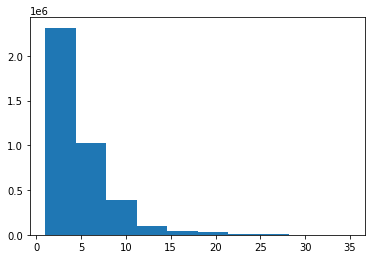

In [155]:
plt.hist(lens, range=(1, 35))
plt.show()

In [133]:
vid_w2v = Word2Vec(sentences=id_seq, window=5, min_count=1, workers=24)

In [136]:
vid_w2v.wv.most_similar('B09JSPLN1M')

[('B09CGY1RYY', 0.9969545006752014),
 ('B07G4JMJPG', 0.9969289898872375),
 ('B074TJS8MV', 0.9967180490493774),
 ('B07Q4WY1C1', 0.9967117309570312),
 ('B099S8N1RJ', 0.9966452717781067),
 ('B09ZQLZCMW', 0.996603786945343),
 ('B09GRNHC3F', 0.9965909123420715),
 ('B09FJVXKRL', 0.9964855909347534),
 ('B0BHSG17TW', 0.9964825510978699),
 ('B08PVS8829', 0.9964374303817749)]

In [137]:
next_item_dict_de['B09JSPLN1M']

['B09M7GY217',
 'B09YS6S48R',
 'B07KDC7PJH',
 'B07MDZ2K4F',
 'B08ZJFWQMV',
 'B09JSPLN1M',
 'B092QMR6T8',
 'B09W9FND7K']

In [158]:
next_item_dict_de['B09M7GY217']

['B09M7GY217',
 'B09BNN1PYQ',
 'B09M7F6F5L',
 'B0B8SBW9S3',
 'B0B6FJJGKB',
 'B09SLPVNBS',
 'B0B6FHVPWW',
 'B09M7GY217',
 'B08HCWPMM1',
 'B0B6FJJGKB',
 'B09M7F6F5L',
 'B084NW53YK',
 'B0B6FHVPWW',
 'B098BH4DD9',
 'B0B6FHVPWW',
 'B0B6FJJGKB',
 'B09V842FCF',
 'B0B6FJJGKB',
 'B0B5Y39G8P',
 'B092MN49FQ',
 'B0BK7P25LJ',
 'B09M7GY217',
 'B09M7J98ZH',
 'B0BK15G5K7',
 'B0BK7P25LJ',
 'B07NQ8MBH4',
 'B09M7F6F5L',
 'B0BK7P25LJ',
 'B0B6FJJGKB',
 'B0BD1251M1',
 'B0B6FHVPWW',
 'B0B2LSR5LV',
 'B0B6FHVPWW',
 'B09M7F6F5L',
 'B09CT7G9YX',
 'B08QYRYH9J',
 'B0B6FHVPWW',
 'B09M7J98ZH',
 'B0BK12QXGF',
 'B0B6FJJGKB',
 'B09M7G1RMT',
 'B09M7G1RMT',
 'B09M7G1RMT',
 'B0B1VSW1VC',
 'B09M7F6F5L',
 'B0B6FJJGKB',
 'B00DCXZY1W',
 'B0BK15G5K7',
 'B0BK7P25LJ',
 'B0B77PY5CS',
 'B0B6FJJGKB',
 'B09M7F6F5L',
 'B0B6FHVPWW',
 'B09M7F6F5L',
 'B0BK15G5K7',
 'B09M7G1RMT',
 'B09M7G1RMT',
 'B074CCYSHN',
 'B09GRQL4VP',
 'B075LHX8XM',
 'B0B6FJJGKB',
 'B0B7J7KDM2',
 'B0B6FJJGKB',
 'B0B7J43WV8',
 'B09GRYB7GK',
 'B08QYRYH9J',
 'B09M7G1R

In [156]:
vid_w2v2 = Word2Vec(sentences=id_seq, window=2, min_count=1, workers=24)

In [157]:
vid_w2v2.wv.most_similar('B09JSPLN1M')

[('B0768LJH91', 0.997101902961731),
 ('B07TVGNZ2L', 0.9969090223312378),
 ('B01N3Z9PFC', 0.99659264087677),
 ('B07TV6YZFW', 0.9965134859085083),
 ('B08VT3ZVLF', 0.996504545211792),
 ('B09LQK46SY', 0.9964858293533325),
 ('B07B539W7W', 0.9964704513549805),
 ('B098MVTR43', 0.9964691996574402),
 ('B0002ASMT4', 0.9964657425880432),
 ('B08R9NRYBB', 0.9964598417282104)]

In [159]:
vid_w2v2.wv.most_similar('B09M7GY217')

[('B09M7G1RMT', 0.996815025806427),
 ('B0B6FJJGKB', 0.994515061378479),
 ('B0B6FHVPWW', 0.9938789010047913),
 ('B0BK7P25LJ', 0.9932073950767517),
 ('B08QYRYH9J', 0.988746166229248),
 ('B08C5HFL69', 0.9882739186286926),
 ('B08JZDG6S1', 0.9875255227088928),
 ('B08C5G5SL8', 0.9861811399459839),
 ('B08DRQNBY8', 0.9847004413604736),
 ('B09GRYB7GK', 0.9844176769256592)]

In [ ]:
# def top_200_count_origin(df_sess_loc, df_test_loc):  # 可以改成从原始数据统计top100
#     k = []
#     v = []

#     for item in next_item_dict:
#         k.append(item)
#         v.append(next_item_dict[item])
        
#     df_next = pd.DataFrame({'item': k, 'next_item': v})
#     df_next = df_next.explode('next_item').reset_index(drop=True)
#     top200 = df_next['next_item'].value_counts().index.tolist()[:200]  # 所有下一跳候选集中最热门的200个

#     return top200 

In [11]:
def top_200_count(next_item_dict):
    k = []
    v = []

    for item in next_item_dict:
        k.append(item)
        v.append(next_item_dict[item])
        
    df_next = pd.DataFrame({'item': k, 'next_item': v})
    df_next = df_next.explode('next_item').reset_index(drop=True)
    top200 = df_next['next_item'].value_counts().index.tolist()[:200]  # 所有下一跳候选集中最热门的200个

    return top200 

In [13]:
top200_de = top_200_count(next_item_dict_de)
top200_jp = top_200_count(next_item_dict_jp)
top200_uk = top_200_count(next_item_dict_uk)

In [14]:
df_test['last_item'] = df_test['prev_items'].apply(lambda x: str2list(x)[-1])

In [168]:
df_sess['last_item'] = df_sess['prev_items'].apply(lambda x: str2list(x)[-1])

In [42]:
df_test['last_item_2'] = df_test['prev_items'].apply(lambda x: str2list(x)[-2])

In [171]:
df_sess['last_item_2'] = df_sess['prev_items'].apply(lambda x: str2list(x)[-2])

In [15]:
df_test.head()

,prev_items,locale,last_item
0,['B08V12CT4C' 'B08V1KXBQD' 'B01BVG1XJS' 'B09VC...,DE,B099NQFMG7
1,['B00R9R5ND6' 'B00R9RZ9ZS' 'B00R9RZ9ZS'],DE,B00R9RZ9ZS
2,['B07YSRXJD3' 'B07G7Q5N6G' 'B08C9Q7QVK' 'B07G7...,DE,B07G7Q5N6G
3,['B08KQBYV43' '3955350843' '3955350843' '39553...,DE,3955350843
4,['B09FPTCWMC' 'B09FPTQP68' 'B08HMRY8NG' 'B08TB...,DE,B09J945WQR


In [45]:
df_test['last_item'] + df_test['last_item_2']

0         B099NQFMG7B01BVG1XJS
1         B00R9RZ9ZSB00R9RZ9ZS
2         B07G7Q5N6GB08C9Q7QVK
3         3955350843B0BJTL2GD5
4         B09J945WQRB09J8V18FL
                  ...         
316966    B0B14M3VZXB077SZ2C3Y
316967    B081YDH55KB0851KTSRZ
316968    B09HL11V5BB08CP8ZD6D
316969    B09JYZ325WB01MCQMORK
316970    B0BG2LZQSLB09TN4MP6V
Length: 316971, dtype: object

In [164]:
w2v_map = defaultdict(list)
for id_ in tqdm(ids_all, total=len(ids_all)):
    w2v_sim = vid_w2v2.wv.most_similar(id_)
    w2v_sim = [x[0] for x in w2v_sim]
    w2v_map[id_] = w2v_sim

  2%|▏         | 27761/1405856 [1:07:23<55:45:05,  6.87it/s] 


KeyboardInterrupt: 

In [139]:
def get_pred_w2v(df_test_loc, next_item_map_loc, top200_loc):
    df_test_loc['next_item_prediction'] = df_test_loc['last_item'].map(next_item_map_loc)

    preds = []
    cnt = 0
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc)):
        pred_orig = row['next_item_prediction']
        w2v_sim = vid_w2v.wv.most_similar(row['last_item'])
        w2v_sim = [x[0] for x in w2v_sim]
        pred = w2v_sim
        prev_items = str2list(row['prev_items'])
        if type(pred_orig) == float:  # pred=nan, 测试集的last_item在之间没有统计出来下一跳，此时用最热门代替
            if len(pred) < 100:  # 小于100，从最热门选
                for i in top200_loc:
                    if i not in pred and i not in prev_items:
                        pred.append(i)
                    if len(pred) >= 100:
                        break
            else:
                pred = pred[:100]
            cnt += 1
        else:
            if len(pred) < 100:  # 小于100，从最热门选
                for i in top200_loc:
                    if i not in pred and i not in prev_items:
                        pred.append(i)
                    if len(pred) >= 100:
                        break
            else:
                pred = pred[:100]
        preds.append(pred)
    print(cnt)
    return preds

In [55]:
def get_pred(df_test_loc, next_item_map_loc, top200_loc):
    df_test_loc['next_item_prediction'] = df_test_loc['last_item'].map(next_item_map_loc)

    preds = []
    cnt = 0
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc)):
        pred_orig = row['next_item_prediction']
        pred = pred_orig
        prev_items = str2list(row['prev_items'])
        if type(pred) == float:  # pred=nan, 测试集的last_item在之间没有统计出来下一跳，此时用最热门代替
            pred = top200_loc[:100]
            cnt += 1
        else:
            if len(pred_orig) < 100:  # 小于100，从最热门选
                for i in top200_loc:
                    if i not in pred_orig and i not in prev_items:
                        pred.append(i)
                    if len(pred) >= 100:
                        break
            else:
                pred = pred[:100]
        preds.append(pred)
    print(cnt)
    return preds

In [169]:
def get_pred_mrr(df_test_loc, next_item_map_loc, top200_loc):
    df_test_loc['next_item_prediction'] = df_test_loc['last_item'].map(next_item_map_loc)

    mrr = []
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc)):
        label = row['next_item']
        pred_orig = row['next_item_prediction']
        pred = pred_orig
        prev_items = str2list(row['prev_items'])
        if type(pred) == float:  # pred=nan, 测试集的last_item在之间没有统计出来下一跳，此时用最热门代替
            pred = top200_loc[:100]
        else:
            if len(pred_orig) < 100:  # 小于100，从最热门选
                for i in top200_loc:
                    if i not in pred_orig and i not in prev_items:
                        pred.append(i)
                    if len(pred) >= 100:
                        break
            else:
                pred = pred[:100]
        try:
            pred_result = pred.index(label)
            mrr.append(1 / (pred_result + 1))
        except:
            mrr.append(0)
    return mrr

In [142]:
preds_de_w2v = get_pred_w2v(df_test[df_test['locale']=='DE'], next_item_map_de, top200_de)
preds_jp_w2v = get_pred_w2v(df_test[df_test['locale']=='JP'], next_item_map_jp, top200_jp)
preds_uk_w2v = get_pred_w2v(df_test[df_test['locale']=='UK'], next_item_map_uk, top200_uk)

100%|██████████| 104568/104568 [1:50:13<00:00, 15.81it/s] 


559


100%|██████████| 96467/96467 [1:41:07<00:00, 15.90it/s]  


636


100%|██████████| 115936/115936 [1:46:27<00:00, 18.15it/s] 


714


In [56]:
preds_de = get_pred(df_test[df_test['locale']=='DE'], next_item_map_de, top200_de)
preds_jp = get_pred(df_test[df_test['locale']=='JP'], next_item_map_jp, top200_jp)
preds_uk = get_pred(df_test[df_test['locale']=='UK'], next_item_map_uk, top200_uk)

100%|██████████| 104568/104568 [00:08<00:00, 12189.12it/s]


559


100%|██████████| 96467/96467 [00:07<00:00, 12259.22it/s]


636


100%|██████████| 115936/115936 [00:09<00:00, 12072.96it/s]

714


In [170]:
preds_de_train = get_pred_mrr(df_sess[df_sess['locale']=='DE'], next_item_map_de, top200_de)
preds_jp_train = get_pred_mrr(df_sess[df_sess['locale']=='JP'], next_item_map_jp, top200_jp)
preds_uk_train = get_pred_mrr(df_sess[df_sess['locale']=='UK'], next_item_map_uk, top200_uk)

100%|██████████| 1182181/1182181 [04:58<00:00, 3959.09it/s]


In [53]:
def get_pred_two(df_test_loc, next_item_map_loc, next_item_map_loc_two, top200_loc):
    df_test_loc['next_item_prediction'] = df_test_loc['last_item'].map(next_item_map_loc)
    df_test_loc['next_item_prediction_two'] = (df_test_loc['last_item'] + df_test_loc['last_item_2']).map(next_item_map_loc_two)

    preds = []

    cnt = 0
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc)):
        pred_orig = row['next_item_prediction']
        pred_orig_two = row['next_item_prediction_two']
        pred = pred_orig_two
        prev_items = str2list(row['prev_items'])
        
        if type(pred) == float:  # pred=nan, 测试集的last_item在之间没有统计出来下一跳，此时用最热门代替
            pred = top200_loc[:100]
            cnt += 1
        else:
            if len(pred) < 100:  # 小于100，从最热门选
                for i in top200_loc:
                    if i not in pred and i not in prev_items:
                        pred.append(i)
                    if len(pred) >= 100:
                        break
            else:
                pred = pred[:100]
        preds.append(pred)
    
    print(cnt)
    return preds

In [54]:
preds_de_m2 = get_pred_two(df_test[df_test['locale']=='DE'], next_item_map_de, next_item_map_de_two, top200_de)
preds_jp_m2 = get_pred_two(df_test[df_test['locale']=='JP'], next_item_map_jp, next_item_map_jp_two, top200_jp)
preds_uk_m2 = get_pred_two(df_test[df_test['locale']=='UK'], next_item_map_uk, next_item_map_uk_two, top200_uk)

100%|██████████| 104568/104568 [00:13<00:00, 7798.74it/s]


49546


100%|██████████| 96467/96467 [00:12<00:00, 7762.83it/s]


45073


100%|██████████| 115936/115936 [00:14<00:00, 7904.19it/s]


58454


In [64]:
def get_pred_two_one(df_test_loc, next_item_map_loc, next_item_map_loc_two, top200_loc):
    df_test_loc['next_item_prediction'] = df_test_loc['last_item'].map(next_item_map_loc)
    df_test_loc['next_item_prediction_two'] = (df_test_loc['last_item'] + df_test_loc['last_item_2']).map(next_item_map_loc_two)

    preds = []

    cnt = 0
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc)):
        pred_orig = row['next_item_prediction']
        pred_orig_two = row['next_item_prediction_two']
        pred = pred_orig_two
        prev_items = str2list(row['prev_items'])
        
        if type(pred) == float:  # pred=nan, 测试集的last_item在之间没有统计出来下一跳，此时用最热门代替
            pred = pred_orig
            if type(pred_orig) == float:
                pred = top200_loc[:100]
                cnt += 1
            else:
                if len(pred) < 100:  # 小于100，从最热门选
                    for i in top200_loc:
                        if i not in pred and i not in prev_items:
                            pred.append(i)
                        if len(pred) >= 100:
                            break
        else:
            if len(pred) < 100:  # 小于100，从最热门选
                for i in pred_orig:
                    if i not in pred and i not in prev_items:
                        pred.append(i)
                    if len(pred) >= 100:
                        break               
                for i in top200_loc:
                    if i not in pred and i not in prev_items:
                        pred.append(i)
                    if len(pred) >= 100:
                        break
            else:
                pred = pred[:100]
        preds.append(pred)
    
    print(cnt)
    return preds

In [65]:
preds_de_m2_1 = get_pred_two_one(df_test[df_test['locale']=='DE'], next_item_map_de, next_item_map_de_two, top200_de)
preds_jp_m2_1 = get_pred_two_one(df_test[df_test['locale']=='JP'], next_item_map_jp, next_item_map_jp_two, top200_jp)
preds_uk_m2_1 = get_pred_two_one(df_test[df_test['locale']=='UK'], next_item_map_uk, next_item_map_uk_two, top200_uk)

100%|██████████| 104568/104568 [00:08<00:00, 12810.21it/s]


559


100%|██████████| 96467/96467 [00:07<00:00, 12602.56it/s]


636


100%|██████████| 115936/115936 [00:09<00:00, 12027.65it/s]


714


In [29]:
predictions = preds_de + preds_jp + preds_uk

In [57]:
predictions = preds_de_m2 + preds_jp_m2 + preds_uk_m2

In [66]:
predictions = preds_de_m2_1 + preds_jp_m2_1 + preds_uk_m2_1

In [143]:
predictions = preds_de_w2v + preds_jp_w2v + preds_uk_w2v

In [144]:
df_test['next_item_prediction'] = predictions

In [145]:
df_test

,prev_items,locale,last_item,next_item_prediction,last_item_2
0,['B08V12CT4C' 'B08V1KXBQD' 'B01BVG1XJS' 'B09VC...,DE,B099NQFMG7,"[B099NR3X6D, B08496TCCQ, B09V7KG931, B089FBVXR...",B01BVG1XJS
1,['B00R9R5ND6' 'B00R9RZ9ZS' 'B00R9RZ9ZS'],DE,B00R9RZ9ZS,"[B001IBFEZQ, B08SFJC7N2, B09ZV58HBQ, B08G8VZC6...",B00R9RZ9ZS
2,['B07YSRXJD3' 'B07G7Q5N6G' 'B08C9Q7QVK' 'B07G7...,DE,B07G7Q5N6G,"[B07YSRXJD3, B0B5G54GYD, B0B5QNFWJ1, B08C9Q7QV...",B08C9Q7QVK
3,['B08KQBYV43' '3955350843' '3955350843' '39553...,DE,3955350843,"[B09HG18NCB, B08KQBYV43, B0B6P4DGDB, B09HL74M7...",B0BJTL2GD5
4,['B09FPTCWMC' 'B09FPTQP68' 'B08HMRY8NG' 'B08TB...,DE,B09J945WQR,"[B09J8V18FL, B09J8VPTTW, B09J8V9RQQ, B09J8T6TT...",B09J8V18FL
...,...,...,...,...,...
316966,['B077SZ2C3Y' 'B0B14M3VZX'],UK,B0B14M3VZX,"[B085GLMYP6, B07VDRXZL8, B09YPZBSMK, B08CKC25T...",B077SZ2C3Y
316967,['B08KFHDPY9' 'B0851KTSRZ' 'B08KFHDPY9' 'B0851...,UK,B081YDH55K,"[B09895QPQF, B09CPP92QM, B0989BHLSY, B09CPNS7X...",B0851KTSRZ
316968,['B07PY1N81F' 'B07Q1Z8SQN' 'B07PY1N81F' 'B07Q1...,UK,B09HL11V5B,"[B07PY1NG3X, B08CP8ZD6D, B06XPKPJFB, B07Q21J9W...",B08CP8ZD6D
316969,['B01MCQMORK' 'B09JYZ325W'],UK,B09JYZ325W,"[B005G3DI32, B08CDZ1D3N, B08CDXK8L2, B00EHJI8G...",B01MCQMORK


In [146]:
df_test['next_item_prediction'].apply(len).describe()

count    316971.0
mean        100.0
std           0.0
min         100.0
25%         100.0
50%         100.0
75%         100.0
max         100.0
Name: next_item_prediction, dtype: float64

In [147]:
df_test[['locale', 'next_item_prediction']].to_parquet('output/submission_task1_sep_rule_w2v_next_one.parquet', engine='pyarrow')

In [62]:
df_test.shape 

(316971, 5)